In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy.integrate as integrate
import warnings
warnings.filterwarnings("ignore")

# Función para convertir un arreglo en un vector columna. La entrada x es una lista o un vector fila.
def col(x):
    return np.array(np.matrix(x)).T

# Punto 2 - Experimento MLE: datos reales invernadero

Las mediciones de temperatura $T$ (unidades en °C) y humedad relativa $H$ (unidades en %) en un invernadero real de un cultivo de rosas se modelan como variables aleatorias continuas a través del vector aleatorio $Z = [T, H]^T$ . Nos indican que asumir que $Z$ es un vector Gaussiano no es suficiente para modelar el comportamiento de la temperatura y la humedad conjuntamente. Nos piden estimar una distribución que se ajuste mejor al verdadero comportamiento del invernadero. Para esto, nos dan en el archivo *greenhouseCaso7.txt* 250 observaciones conjuntas de las variables de temperatura $T$ (primera columna) y de humedad $H$ (segunda columna).

## a) Grafique las observaciones de temperatura vs humedad, y realice una inspección visual de los datos analizando su comportamiento.

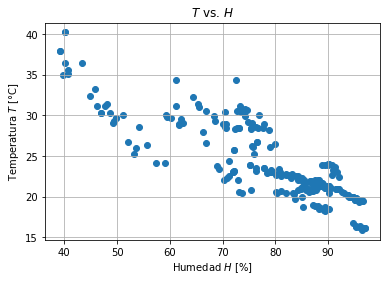

In [2]:
# Se importan los datos del .txt
filename = 'greenhouseCaso7.txt'
T = np.loadtxt(filename)[:, 0]
H = np.loadtxt(filename)[:, 1]

# Se grafica T contra H en el plano R^2.
plt.scatter(H, T)
plt.grid()
plt.xlabel(r'Humedad $H$ [%]')
plt.ylabel(r'Temperatura $T$ [°C]')
plt.title(r'$T$ vs. $H$')
plt.savefig('TvsH.eps', format='eps')

### Se puede notar una gran concentración de datos entre el 80% y 90% de humendad (para temperaturas entre los 15 °C y 25 °C), otra concentración sentre el 60% y 80% (temperaturas entre 25 °C y 35 °C) y una última concentración baja de datos entre el 40% y 60% de humedad (para temperaturas entre los 24 °C y los 40 °C).

## b) Estime la mejor distribución Gaussiana de $Z$ (una sola Gaussiana) utilizando MLE, e indique la función resultante. Grafique las observaciones de temperatura vs humedad, y traslape el contorno de la función de densidad. Comente los resultados obtenidos. Recuerde que para estimar la distribución Gaussiana basta con estimar el vector de valores esperados y la matriz de covarianza. **No puede utilizar funciones predefinidas para estimar el vector de medias y la matriz de covarianza. Implemente su propia rutina para hacer este cálculo.**

Estimación de la media mu_Z: 
 [[23.8244]
 [79.2048]]

Estimación de la matriz de covarianza Q_Z: 
 [[ 24.16586811 -63.29023807]
 [-63.29023807 220.63716562]]



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


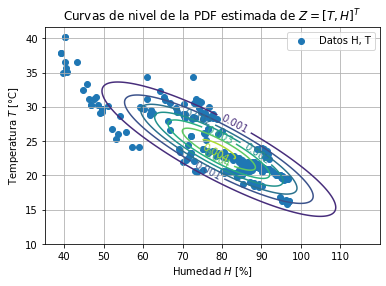

In [3]:
# Creamos vectores de la forma z = [T, H]^T donde T es temperatura y H es la humedad. Los vamos a colocar en una matriz TH de 2xlen(T), donde len(T) = len(H).
TH = np.zeros((2, len(T)))
n, m = np.shape(TH)

# Llenamos la matriz TH
for i in range(m):
    TH[0, i] = T[i]
    TH[1, i] = H[i]

# Creamos la estimación de la media mu_Z
mu_Z = np.zeros((2,1))
for i in range(m):
    mu_Z = mu_Z + col(TH[:, i])
mu_Z = mu_Z/m
print(f'Estimación de la media mu_Z: \n {mu_Z}\n')

# Creamos la estimación de la matriz de covarianza
Q_Z = np.zeros((2,2))
for i in range(m):
    Q_Z = Q_Z + (col(TH[:,i])-mu_Z)@(col(TH[:,i])-mu_Z).T
Q_Z = Q_Z/(m-1)
print(f'Estimación de la matriz de covarianza Q_Z: \n {Q_Z}\n')

# Se generan vectores con valores de 'h' y 't' para generar una malla (H1, T1) sobre la cual dibujar las curvas de nivel.
step = 0.05
h = np.arange(40, 120, step)
t = np.arange(10, 40, step)

# Se genera la malla (H1, T1). H1 y T1 son matrices que representan los puntos en el plano R^2.
H1, T1 = np.meshgrid(h, t)

# Se usa la función multivariate_normal para definir la función Gaussiana en el eje Z que se genera con los diferentes datos en H1 y T1.
# Se define el vector Z como la pdf Gaussiana representada por el vector de medias mu_Z y la matriz de covarianza Q_Z.
pos = np.dstack((T1, H1))
rv = multivariate_normal([float(mu_Z[0]), float(mu_Z[1])], Q_Z)
Z = rv.pdf(pos)

# Se grafican las curvas de nivel de la pdf de Z junto con los datos T y H entregados en el archivo de texto.
fig, ax = plt.subplots()
CS = plt.contour(H1, T1, Z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_xlabel(r'Humedad $H$ [%]')
ax.set_ylabel(r'Temperatura $T$ [°C]')
ax.set_title(r'Curvas de nivel de la PDF estimada de $Z = [T, H]^T$')
ax.grid()
plt.scatter(H, T)
plt.legend(['Datos H, T'])
plt.savefig('TvsH_curvasnivel.eps', format='eps')
plt.show()

### Se puede notar que asumir que $Z$ es un vector aleatorio Gaussiano conjunto no es del todo suficiente para dar una buena aproximación de la relación entre temperatura y humedad, pues aunque el centro de la campana de Gauss se ubica en un sitio de alta concentración de datos, hay tres diferentes áreas de alta concentración de datos que solo una función Gaussiana no alcanza a cubrir y les asignaría una baja probabilidad de ocurrencia a datos que en realidad tienen una mayor probabilidad de ocurrencia.

## c) Implemente el algoritmo EM, y estime la función de densidad Z como una combinación de dos funciones de densidad Gaussianas. Es decir, 
## $$f_Z(z) = \sum_{k=1}^{2} \alpha_k N(z; \mu_k, Q_k). $$
## Grafique de nuevo las observaciones, y traslape el contorno de la función de densidad combinada $f_Z(z)$ (NO el contorno de cada función de densidad base por separado) para varias de las iteraciones del algoritmo. Comente los resultados obtenidos. **No puede utilizar funciones predefinidas para obtener la combinación de Gaussianas. Implemente su propia rutina del algoritmo EM.**

In [4]:
# Función de densidad de probabilidad Gaussiana multivariable.
def gauss(x, mu, Cx):
    n = np.shape(Cx)[0]
    return (1/(np.sqrt((2*np.pi)**(n)*(np.linalg.det(Cx)))))*np.exp((-1/2)*(np.transpose(x-mu)@np.linalg.inv(Cx))@(x-mu))

# Función para crear una nueva lista de thetas (parámetros), dependiendo del número de funciones n que se quieran combinar.
def create_thetas(n):
    x = [[] for num in range(n)]
    return x

# Función para graficar resultados del algoritmo EM para combinación de 2 Gaussianas
def graficar2gauss(c, alphas, params):

    HPoints = []
    TPoints = []

    rango = range(0, 120, 1)

    for val in rango:
        HPoints.append(val)
        TPoints.append(val)

    # Valores de Z como una matriz
    ZPoints = np.ndarray((len(HPoints),len(TPoints)))

    # Calculamos el valor correspondiente a cada par de coordenadas h, t
    for h in HPoints:
        for t in TPoints:
            v = np.array([[HPoints[h]], [TPoints[t]]])
            f = alphas[0]*gauss(v, params[0][0], params[0][1]) + alphas[1]*gauss(v, params[1][0], params[1][1])
            ZPoints[h][t] = f

    # Gráfica
    plt.figure()
    contours = plt.contour(HPoints, TPoints, ZPoints)
    plt.clabel(contours, inline=1, fontsize=10)
    plt.grid()
    plt.scatter(H, T)
    plt.title(f'Temperatura vs Humedad (iteración {c})')
    plt.xlabel(r'Humedad $H$ [%]')
    plt.ylabel(r'Temperatura $T$ [°C]')
    plt.xlim([35, 105])
    plt.ylim([10, 43])
    plt.savefig(f'EM_2_iteracion{c}.eps', format='eps')
    plt.show()


# Función para graficar resultados del algoritmo EM para combinación de 3 Gaussianas
def graficar3gauss(c, alphas, params):

    HPoints = []
    TPoints = []

    rango = range(0, 120, 1)

    for val in rango:
        HPoints.append(val)
        TPoints.append(val)

    # Valores de Z como una matriz
    ZPoints = np.ndarray((len(HPoints),len(TPoints)))

    # Calculamos el valor correspondiente a cada par de coordenadas h, t
    for h in HPoints:
        for t in TPoints:
            v = np.array([[HPoints[h]], [TPoints[t]]])
            f = alphas[0]*gauss(v, params[0][0], params[0][1]) + alphas[1]*gauss(v, params[1][0], params[1][1]) + alphas[2]*gauss(v, params[2][0], params[2][1])
            ZPoints[h][t] = f

    # Gráficas
    plt.figure()
    contours = plt.contour(HPoints, TPoints, ZPoints)
    plt.clabel(contours, inline=1, fontsize=10)
    plt.grid()
    plt.scatter(H, T)
    plt.title(f'Temperatura vs Humedad (iteración {c})')
    plt.xlabel(r'Humedad $H$ [%]')
    plt.ylabel(r'Temperatura $T$ [°C]')
    plt.xlim([35, 105])
    plt.ylim([10, 43])
    plt.savefig(f'EM_3_iteracion{c}.eps', format='eps')
    plt.show()
        

### Definición del algoritmo

In [5]:
# Entradas
# maxIt: máximas iteraciones que se permite que el algoritmo haga.
# tol: tolerancia del algoritmo para la condición de terminación.
# k: número de funciones Gaussianas que se planea combinar.
# thetak0: lista de parámetros thetak, cada elemento de la lista es una lista que contiene una media y una matriz de covarianza.
# alphak: lista de parámetros alphak, cada elemento de la lista es un valor de alpha.
# datos: arreglo de los datos sobre los cuales se quiere encontrar la función de densidad compuesta. Se ingresan en forma de matriz en donde cada fila es un dato y cada columna es un componente del dato.

# Salidas
# thetak_final: arreglo de parámetros de las funciones combinadas que forman la función compuesta que mejor se ajusta a los datos.
# alphak_final: arreglo de pesos de las funciones combinadas que forman la función compuesta que mejor se ajusta a los datos.
# c: Número de iteraciones que tomó el algoritmo
def EM(maxIt, tol, k, thetak0, alphak, datos):

    c = 0 # Contador para el while.
    m = len(datos) # Cantidad de datos.
    Y = np.zeros((m,len(thetak0))) # Matriz de gammas: cada columna corresponde a cada gamma_k.
    norma = 100 # Norma para la condición de terminación.
    regu = 0.01*np.eye(2)  # Parámetro de regularización.

    while(c < maxIt and norma > tol ):

        # E-Step
        den = 0
        for r in range(len(thetak0)):
            Nm = np.zeros((m, 1))
            for i in range(m):
                Nm[i] = gauss(col(datos[i]), thetak0[r][0], thetak0[r][1] + regu)
            den = den + alphak[r]*Nm

        num = 0
        for r in range(len(thetak0)):
            Nm = np.zeros((m, 1))
            for i in range(m):
                Nm[i] = gauss(col(datos[i]), thetak0[r][0], thetak0[r][1] + regu)
            num = alphak[r]*Nm
            Y[:,r] = col(np.divide(num, den)) # Se va llenando la matriz de gammas.

        # M-Step

        # En este recorrido se calcula el Nk
        Nk = []
        suma = 0
        for j in range(len(thetak0)):
            suma = 0
            for i in range(m):
                suma = suma + Y[:,j][i]
            Nk.append(suma)

        # En este recorrido se calcula el alphak
        alphak = []
        for i in range(len(thetak0)):
            alphak.append(Nk[i]/m)

        # En este recorrido se calculan las nuevas medias (muk).
        muk = []
        suma = 0
        for j in range(len(thetak0)):
            suma = 0
            for i in range(m):
                suma = suma + Y[:,j][i]*col(datos[i])
            muk.append(suma/Nk[j])

        # En este recorrido se calculan las nuevas matrices de covarianza (Ck).
        Ck = []
        suma = 0
        for j in range(len(thetak0)):
            suma = 0
            for i in range(m):
                dato = col(datos[i])
                suma = suma + Y[:,j][i]*(dato-muk[j])@(dato-muk[j]).T
            Ck.append(suma/Nk[j])

        # Se crea una nueva lista de thetas, para luego guardar los encontrados en la iteración actual.
        thetak_new = create_thetas(len(thetak0))
        for i in range(len(thetak0)):
            thetak_new[i].append(muk[i])
            thetak_new[i].append(Ck[i])

        # Se calcula la diferencia entre los parámetros nuevos y los anteriores y se calcula su norma para saber si tienen valores parecidos.
        norma = np.linalg.norm(thetak_new[0][0] - thetak0[0][0])

        # El valor "nuevo" de thetak ahora será el usado en la siguiente iteración.
        thetak0 = thetak_new
        c+=1
        
        # Graficar el resultado para cierto número de iteraciones.
        its = [1, 5, 10, 15, 20, 25, 30, 35, 50, 75, 100]
        # Si se combinaron 2 Gaussianas
        if k == 2:
            for it in its:
                if c == it:
                    graficar2gauss(it, alphak, thetak0)
        elif k == 3: # Si se combinaron 3 Gaussianas
            for it in its:
                if c == it:
                    graficar3gauss(it, alphak, thetak0)
                    

    # # Cuando se cumpla alguna de las condiciones de terminación (iteraciones o norma).
    thetak_final = thetak0
    alphak_final = alphak

    return thetak_final, alphak_final, c

### Combinación de 2 Gaussianas

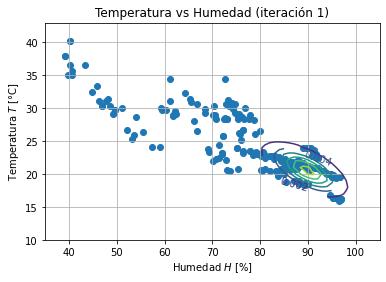

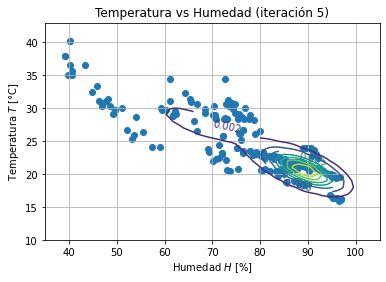

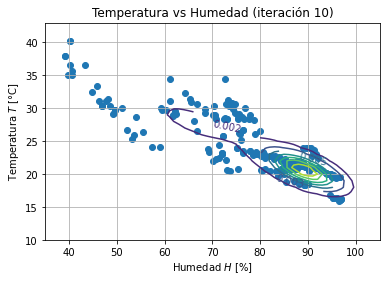

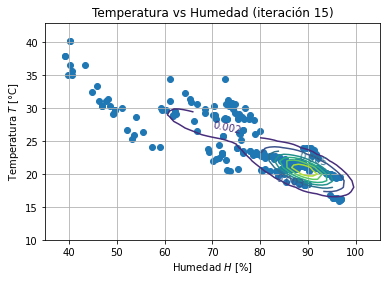

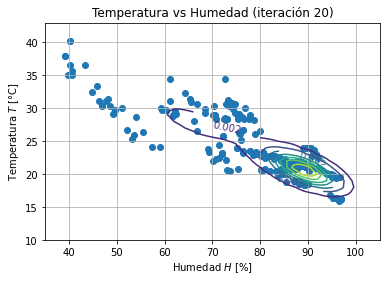

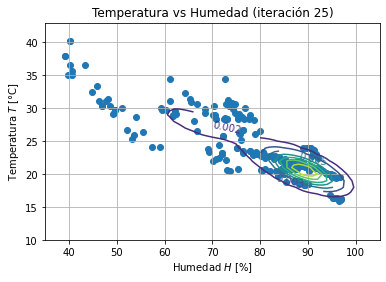

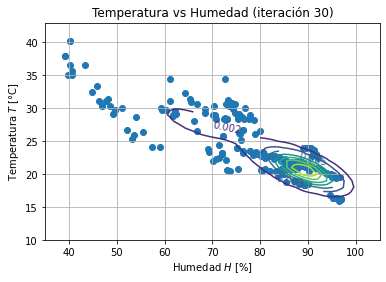

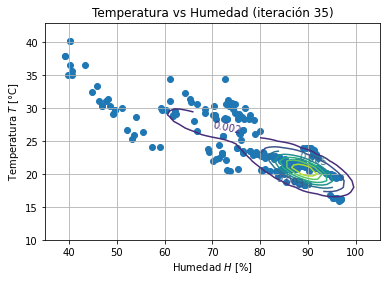

In [6]:
# Condiciones iniciales
k = 2

mu1 = np.array([[20], [70]])
mu2 = np.array([[30], [90]])

C1 = np.eye(2)
C2 = np.eye(2)

thetak = []
theta1 = [mu1, C1]
theta2 = [mu2, C2]

thetak.append(theta1)
thetak.append(theta2)

alphak = []
alpha1 = 1/2
alpha2 = 1/2

alphak.append(alpha1)
alphak.append(alpha2)

maxIts = 1000
tol = 10**-5

TH2 = TH.T

# Se corre el algoritmo
params2, alphas2, its2 = EM(maxIts, tol, k, thetak, alphak, TH2)


### Gráfica del resultado del algoritmo al llegar a la convergencia

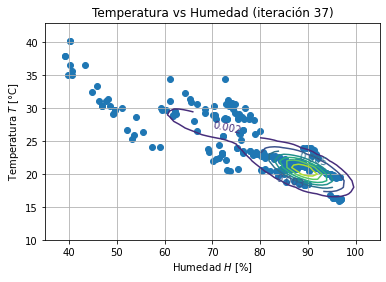

RESULTADOS FINALES

Número de iteraciones: 37

Media de la primera función:
[[27.66458727]
 [67.26441891]]

Matriz de covarianza de la primera función:
[[ 21.04620146 -45.92467746]
 [-45.92467746 187.80100245]]

alpha_1 = 0.458
--------------------

Media de la segunda función:
[[20.58238175]
 [89.28528062]]

Matriz de covarianza de la segunda función:
[[ 3.66068843 -6.0919183 ]
 [-6.0919183  24.7500881 ]]

alpha_2 = 0.542


In [7]:
graficar2gauss(its2, alphas2, params2)
print(f'RESULTADOS FINALES\n')
print(f'Número de iteraciones: {its2}\n')
print(f'Media de la primera función:\n{params2[0][0]}\n')
print(f'Matriz de covarianza de la primera función:\n{params2[0][1]}\n')
print(f'alpha_1 = {np.round(alphas2[0], 3)}')
print('--------------------\n')
print(f'Media de la segunda función:\n{params2[1][0]}\n')
print(f'Matriz de covarianza de la segunda función:\n{params2[1][1]}\n')
print(f'alpha_2 = {np.round(alphas2[1], 3)}')

## d) Repita el punto c) ahora con 3 funciones Gaussianas. Indique cuál de los tres resultados (i.e., 1, 2, o 3 Gaussianas ) usted consideraría genera un mejor ajuste de los datos.

### Combinación de 3 Gaussianas

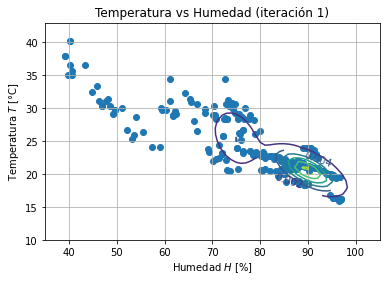

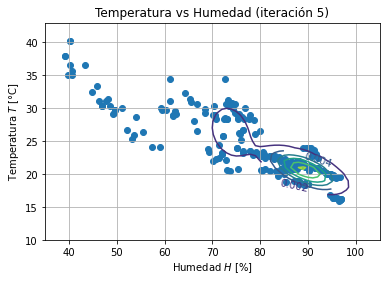

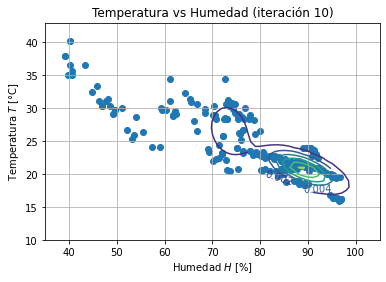

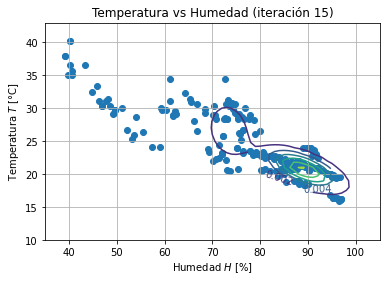

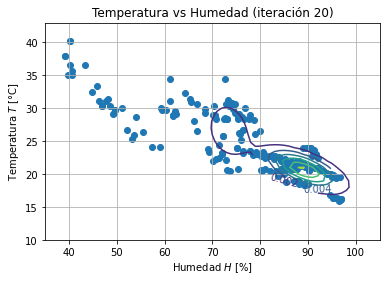

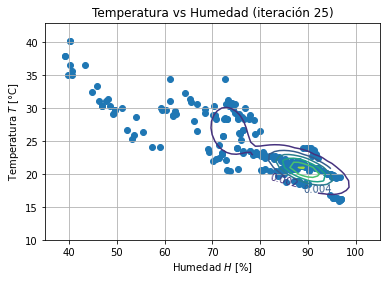

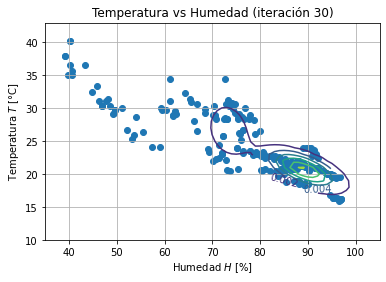

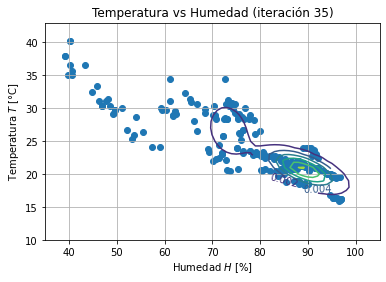

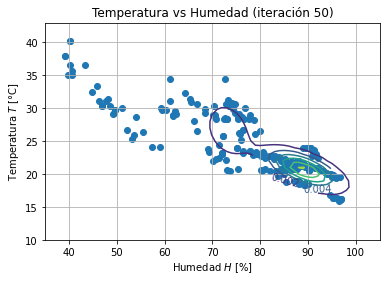

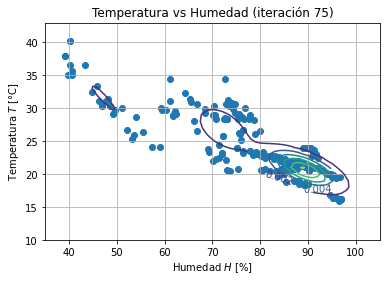

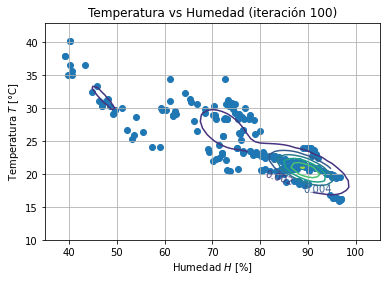

In [8]:
# Condiciones iniciales
k = 3

mu1 = np.array([[20], [70]])
mu2 = np.array([[30], [90]])
mu3 = np.array([[30], [60]])

C1 = np.eye(2)
C2 = np.eye(2)
C3 = np.eye(2)

thetak = []
theta1 = [mu1, C1]
theta2 = [mu2, C2]
theta3 = [mu3, C3]

thetak.append(theta1)
thetak.append(theta2)
thetak.append(theta3)

alphak = []
alpha1 = 1/3
alpha2 = 1/3
alpha3 = 1/3

alphak.append(alpha1)
alphak.append(alpha2)
alphak.append(alpha3)

maxIts = 1000
tol = 10**-5

TH2 = TH.T

# Se corre el algoritmo
params3, alphas3, its3 = EM(maxIts, tol, k, thetak, alphak, TH2)

### Gráfica del resultado al llegar a la convergencia

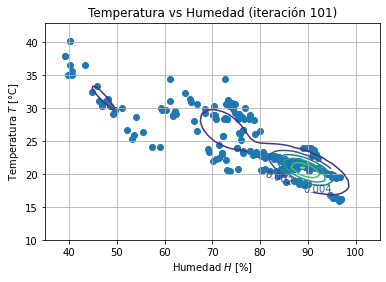

RESULTADOS FINALES
Número de iteraciones: 101

Media de la primera función:
[[26.88264238]
 [72.24202129]]

Matriz de covarianza de la primera función:
[[12.12630931 -9.41311052]
 [-9.41311052 32.53662372]]

alpha_1 = 0.313
--------------------

Media de la segunda función:
[[20.59024926]
 [89.45607774]]

Matriz de covarianza de la segunda función:
[[ 3.74190441 -5.60730383]
 [-5.60730383 22.82868432]]

alpha_2 = 0.572
--------------------

Media de la tercera función:
[[31.56002422]
 [47.27707152]]

Matriz de covarianza de la tercera función:
[[ 20.16885683 -24.09179452]
 [-24.09179452  31.96415532]]

alpha_3 = 0.115


In [9]:
graficar3gauss(its3, alphas3, params3)
print(f'RESULTADOS FINALES')
print(f'Número de iteraciones: {its3}\n')
print(f'Media de la primera función:\n{params3[0][0]}\n')
print(f'Matriz de covarianza de la primera función:\n{params3[0][1]}\n')
print(f'alpha_1 = {np.round(alphas3[0], 3)}')
print('--------------------\n')
print(f'Media de la segunda función:\n{params3[1][0]}\n')
print(f'Matriz de covarianza de la segunda función:\n{params3[1][1]}\n')
print(f'alpha_2 = {np.round(alphas3[1], 3)}')
print('--------------------\n')
print(f'Media de la tercera función:\n{params3[2][0]}\n')
print(f'Matriz de covarianza de la tercera función:\n{params3[2][1]}\n')
print(f'alpha_3 = {np.round(alphas3[2], 3)}')

### Es claro que la combinación de 3 Gaussianas genera el mejor ajuste a los datos en comparación con la combinación de 2 Gaussianas y solo 1 (asumir que Z es un vector aleatorio Gaussiano conjunto). Esto se puede notar claramente de la gráfica anterior, en la que hay una campana de Gauss para cada una de las tres zonas del plano en la que hubo mayor concentración de datos.

## e) Se tienen 50 nuevos datos de temperatura en el archivo *greenhouse50temp.txt* para los cuales se desconoce el valor asociado de humedad.

### i) Con el modelo obtenido en el enunciado b), obtenga un estimador MMSE sin restricciones de $H$ basado en las observaciones de $T$. En este caso, como se tiene sólo una Gaussiana conjunta, este estimador sin restricciones es el mismo lineal. Muestre claramente la ecuación del estimador y estime las observaciones de $H$ asociadas a las 50 observaciones recolectados de temperatura. Grafique $T$ vs $\hat{H}$ , donde $\hat{H}(t)$ se refiere a la estimación de la humedad basado en la observación de temperatura $t$.

### La PDF conjunta que resulta de estos datos estimados está dada por

### $$f_Z(z) = \frac{1}{2\pi\sqrt{\det{Q_Z}}}\exp\left({-\frac{1}{2}}(z - \mu_Z)^T Q_Z^{-1} (z - \mu_Z)\right)$$

### en donde

### $$z = \begin{bmatrix} t \\ h \end{bmatrix}$$

### $$\mu_Z = \begin{bmatrix} \mu_T \\ \mu_H \end{bmatrix} = \begin{bmatrix} 23.824 \\ 79.205 \end{bmatrix}$$

### $$Q_Z = \begin{bmatrix} \sigma_{T}^2 & \text{cov}(T, H) \\ \text{cov}(T, H) & \sigma_{H}^2 \end{bmatrix} = \begin{bmatrix} 24.165 & -63.290 \\ -63.290 & 220.637 \end{bmatrix}$$

### Se sabe que el estimador MMSE sin restricciones de H basado en observaciones de T está dado por 

### $$\hat{H}_{\text{MMSE}}(T) = E[H] + \frac{\text{cov}(H, T)}{\sigma_T^2}[T - E[T]]$$

Text(0.5, 1.0, 'Estimador LMMSE de $H$ basado en $T$')

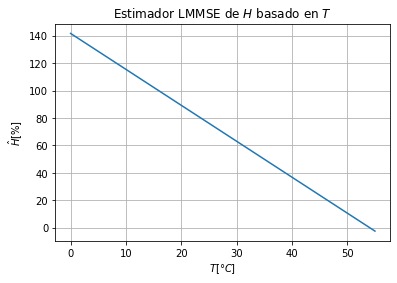

In [10]:
# Se usa el estimador MMSE sin restricciones de H basado en T descrito anteriormente para estimar el valor de H basado en las observaciones de T entregadas en el archivo greenhouse50temp.txt.
filename2 = 'greenhouse50temp.txt'
T50 = np.loadtxt(filename2)

# Se crea estimador lineal de H.
def Hhat(muH, muT, covHT, sigmaT, T):
    return muH + (covHT/sigmaT)*(T-muT)

# Se estima el valor de H para los valores de T_est.
T_est = np.linspace(0, 55, 50)
Hh = []

# Para cada valor de T en T_est, calcular su H estimado correspondiente.
for i in range(len(T_est)):
    Hh.append(Hhat(mu_Z[1], mu_Z[0], Q_Z[1, 0], Q_Z[0,0], T_est[i]))

# Se grafica el estimador LMMSE de H basado en T.
plt.plot(T_est, Hh)
plt.grid()
plt.xlabel(r'$T [°C]$')
plt.ylabel(r'$\hat{H} [\%]$')
plt.title(r'Estimador LMMSE de $H$ basado en $T$')

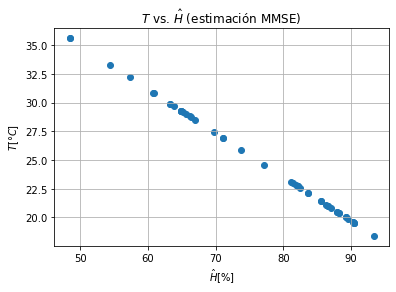

In [11]:
# Se estiman los valores de humedad con respecto a los obtenidos en el archivo greenhouse50temp.txt.
H50_estimados = np.zeros((len(T50), 1))
for i in range(len(T50)):
    H_estimado = np.round(Hhat(mu_Z[1], mu_Z[0], Q_Z[1, 0], Q_Z[0,0], T50[i]), 1)
    H50_estimados[i] = H_estimado

# Se grafican los valores de T del archivo greenhouse50temp.txt contra los valores recientemente estimados.
plt.scatter(H50_estimados, T50)
plt.grid()
plt.xlabel(r'$\hat{H} [\%]$')
plt.ylabel(r'$T [°C]$')
plt.title(r'$T$ vs. $\hat{H}$ (estimación MMSE)')
plt.savefig(f'TvsHestimMMSE.eps', format='eps')

### ii) Sea $f_Z(t, h) = \sum_{k=1}^{3} \alpha_k N(t, h; \mu_k, Q_k)$ la distribución encontrada en el enunciado d). Escriba una rutina que, dada una observación de temperatura t, calcule 
### $$\hat{H}(t) = E[H|T=t] = \int_{-\infty}^{\infty}h f_H(h|T=t)dh$$
### Utilizando esta rutina, encuentre la estimación de la humedad basado en las 50 observaciones de temperatura. Grafique $T$ vs. $\hat{H}$, donde $\hat{H}(t)$ se refiere a la estimación de la humedad basado en la observación de temperatura $t$.

### Recuede que 
### $$f_H(h|T=t) = \frac{f_Z(t,h)}{f_T(t)}$$
### y que
### $$f_T(t) = \int_{-\infty}^{\infty}f_Z(t,h)dh$$

In [12]:
# Descripción de la función scipy.integrate.
# The first argument to quad is a “callable” Python object (i.e., a function, method, or class instance). The next two arguments are the limits of integration. 
# The return value is a tuple, with the first element holding the estimated value of the integral and the second element holding an upper bound on the error.

# Definimos la función f_Z(t, h)
def f_Z(h,t):
    return float(alphas3[0]*gauss(np.array([[t,h]]).T, params3[0][0], params3[0][1]) + alphas3[1]*gauss(np.array([[t,h]]).T, params3[1][0], params3[1][1]) + alphas3[2]*gauss(np.array([[t,h]]).T, params3[2][0], params3[2][1]))

# Definimos la función f_H(t, h)
def f_H(h,t):
    f_T = integrate.quad(f_Z, -np.inf, np.inf, args=(t,))
    return (f_Z(h,t))/(f_T[0])

# Definimos el integrando para calcular el estimado de H.
def integrando(h,t):
    return h*f_H(h,t)

# Función para calcular el estimado de H a partir de valores conocidos de T. Se integra de 0 a 100 en lugar de -inf a inf para evitar errores de underflow en el cómputo de las integrales.
def Hhat_integral(t):
    return integrate.quad(integrando, 0, 100, args=(t,))

### Se encuentra la estimación de la humedad basado en las 50 observaciones de temperatura.

In [13]:
# Se estiman los valores de humedad con respecto a los obtenidos en el archivo greenhouse50temp.txt.
H50_estimados_integral = np.zeros((len(T50), 1))
for i in range(len(T50)):
    H_estimado = Hhat_integral(T50[i])
    H50_estimados_integral[i] = H_estimado[0]

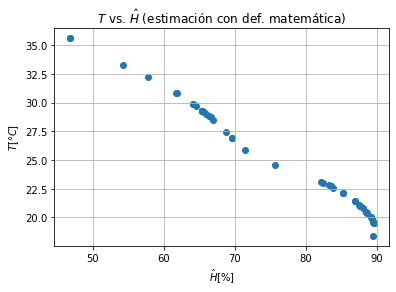

In [14]:
# Se grafican los valores de T del archivo greenhouse50temp.txt contra los valores recientemente estimados.
plt.scatter(H50_estimados_integral, T50)
plt.grid()
plt.xlabel(r'$\hat{H} [\%]$')
plt.ylabel(r'$T [°C]$')
plt.title(r'$T$ vs. $\hat{H}$ (estimación con def. matemática)')
plt.savefig(f'TvsHestimIntegrales.eps', format='eps')

### iii) Eventualmente se pudo recuperar las observaciones reales de humedad asociadas a las 50 observaciones de temperatura. Éstas se encuentran en el archivo greenhouse50hum.txt. Se quiere determinar cuál de los dos estimadores de humedad fue el más preciso: el encontrado en el enunciado (i) o el encontrado en el enunciado (ii). Para eso, en ambos casos, calcule el error:
### $$error = \frac{1}{50}\sum_{i=1}^{50}\left(h_i - \hat{H}(t_i)\right)^2$$
### donde $h_i$ y $t_i$ se refieren a los valores de humedad y temperatura reales, y $\hat{H}(t_i)$ se refiere a la estimación de $h_i$ dada por cada estimador por separado.  Basado en este error, determine cuál de los estimadores sería el más adecuado de utilizar con respecto a precisión y tiempo de cómputo.

In [15]:
# Se define la función de error
# h y Hhat son vectores del mismo tamaño.
# Retorna el valor numérico de la función de error
def error(h, Hhat):
    suma = 0
    for i in range(len(h)):
        suma = suma + (h[i] - Hhat[i])**2
    return np.round(float((1/len(h))*suma), 2)

# Importamos los datos reales de humedad
filename3 = 'greenhouse50hum.txt'
H50 = np.loadtxt(filename3)

# Calculamos el error obtenido para el estimador lineal MMSE (una sola Gaussiana).
error1 = error(H50, H50_estimados)

# Calculamos el error obtenido para el estimador dado por la definición matemática.
error3 = error(H50, H50_estimados_integral)

print(f'Error con 1 Gaussiana:\n {error1}\n')
print(f'Error con 3 Gaussianas:\n {error3}\n')

if(error1>error3):
    print('El estimador más adecuado a utilizar con respecto a precisión es el estimador hallado a partir de la combinación de 3 Gaussinas.')
else:
    print('El estimador más adecuado a utilizar con respecto a precisión es el estimador hallado a partir de 1 Gaussiana.')

print('El estimador más adecuado a utilizar con respecto a tiempo de cómputo es el estimador hallado a partir de 1 Gaussiana.')

Error con 1 Gaussiana:
 64.77

Error con 3 Gaussianas:
 64.74

El estimador más adecuado a utilizar con respecto a precisión es el estimador hallado a partir de la combinación de 3 Gaussinas.
El estimador más adecuado a utilizar con respecto a tiempo de cómputo es el estimador hallado a partir de 1 Gaussiana.


### Gráfica de comparación entre estimadores

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


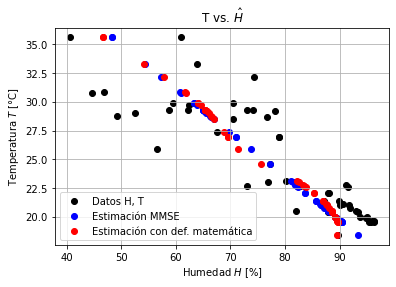

In [16]:
plt.scatter(H50, T50, c='k', label='Datos H, T')
plt.scatter(H50_estimados, T50, c='b', label='Estimación MMSE')
plt.scatter(H50_estimados_integral, T50, c='r', label='Estimación con def. matemática')
plt.grid()
plt.legend()
plt.xlabel(r'Humedad $H$ [%]')
plt.ylabel(r'Temperatura $T$ [°C]')
plt.title(r'T vs. $\hat{H}$')
plt.savefig('comparacionEstimadores.eps', format='eps')